# Multilayer perceptron to classify english spoken words 0 to 9

## Dataset

About 2000 voice recordings are used in the analysis. This dataset is obtained from https://github.com/Jakobovski/free-spoken-digit-dataset

## Mel Frequency Cepstral Coefficient

Python_speech_feature module is used to convert raw audio recordings (.wav audio files) to their corresponding Mel frequency cepstral coefficients (MFCCs). These MFCCs are used to train and test the model. The dataset is split into training(80%) and testing(20%). 

In [14]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

def get_mfcc(file_path):
    (rate, sig) = wav.read(file_path)
    return mfcc(sig, rate)

In [15]:
def split_train_test(data, test_ratio, seed):
    '''
    divides data into training and testing sets
    '''
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data[train_indices], data[test_indices]

In [16]:
folder_path = r'''/home/sagar/GitHub-Repos/Speech Recognition/recordings'''

In [17]:

import os
import numpy as np
from numpy import newaxis
labels = []
fileNames = os.listdir(folder_path)
mel_freq = np.empty(shape = (len(fileNames), 60, 12))
for fileName in fileNames:
    #label = int(fileName[0])
    path = os.path.abspath(os.path.join(folder_path, fileName))
    mfcc_temp = get_mfcc(path)                                   
    mfcc_temp.resize(1,60,12)
    np.append(mel_freq, mfcc_temp, axis=0)
    labels.append(int(fileName[0]))

In [18]:
targets = np.array(labels)

In [19]:
train_data, test_data = split_train_test(mel_freq, 0.1, 1)
train_labels, test_labels = split_train_test(targets, 0.1, 1)

In [20]:
# one-hot encoding of labels into 10 categories (0 to 9)
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [21]:
train_data.shape

(1800, 60, 12)

## Model

The model used here is a Sequential model containing four Dense layers. The first three layers uses "relu" activation function and contains 64 hidden layers each. The last layer has an activation function of "softmax" with 10 hidden layers, this layer outputs the probability of the observations for all 10 classes (0 to 9).

"Categorical crossentropy" is used as the loss function to measure the model's performance with accuracy as the metrics and "rmsprop" as the optimizer.

During training, the model is trained on 800 datapoints and is validated on the other 800. Using validation allows to reduces overfitting by tuning hyperparameters.

In [22]:

# from keras import models, layers

# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_shape=(60,12)))
# model.add(layers.Dense(256,  activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64,  activation='relu'))
# model.add(layers.Dense(10, activation='softmax')) 


# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 60, 256)           3328      
_________________________________________________________________
dense_6 (Dense)              (None, 60, 256)           65792     
_________________________________________________________________
flatten_2 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                983104    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 1,052,874
Trainable params: 1,052,874
Non-trainable params: 0
_________________________________________________________________


In [55]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, 10, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(layers.Dense(10, activation='softmax')) 


model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 51, 32)            3872      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                8010      
Total params: 11,882
Trainable params: 11,882
Non-trainable params: 0
_________________________________________________________________


In [24]:
# ## Validating the approach

# x_val = train_data[:800]
# partial_x_train = train_data[800:]

# y_val = train_labels[:800]
# partial_y_train = train_labels[800:]

In [25]:
partial_x_train.shape

(800, 60, 12)

In [54]:
# history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=50, validation_data=(x_val, y_val))
history = model.fit(train_data, train_labels, epochs=20, batch_size=50, validation_split=0.2)

Train on 1440 samples, validate on 360 samples
Epoch 1/20
1440/1440 [==============================] - 2s 2ms/step - loss: 2.3035 - acc: 0.0896 - val_loss: 2.3029 - val_acc: 0.0944
Epoch 2/20
1440/1440 [==============================] - 0s 329us/step - loss: 2.3034 - acc: 0.0937 - val_loss: 2.3029 - val_acc: 0.0944
Epoch 3/20
1440/1440 [==============================] - 0s 169us/step - loss: 2.3033 - acc: 0.0917 - val_loss: 2.3027 - val_acc: 0.0944
Epoch 4/20
1440/1440 [==============================] - 0s 181us/step - loss: 2.3032 - acc: 0.0854 - val_loss: 2.3032 - val_acc: 0.0944
Epoch 5/20
1440/1440 [==============================] - 1s 536us/step - loss: 2.3032 - acc: 0.0993 - val_loss: 2.3031 - val_acc: 0.0944
Epoch 6/20
1440/1440 [==============================] - 1s 369us/step - loss: 2.3032 - acc: 0.0875 - val_loss: 2.3030 - val_acc: 0.0944
Epoch 7/20
1440/1440 [==============================] - 1s 681us/step - loss: 2.3033 - acc: 0.0993 - val_loss: 2.3029 - val_acc: 0.0917
Epo

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

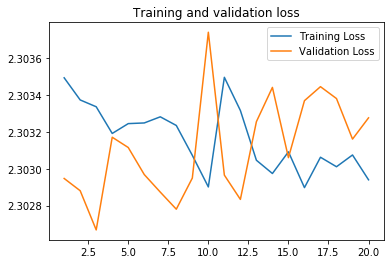

In [59]:
# Plotting training and validation loss

import matplotlib.pyplot as plt

epochs = range(1, len(history_dict['loss'])+1)

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

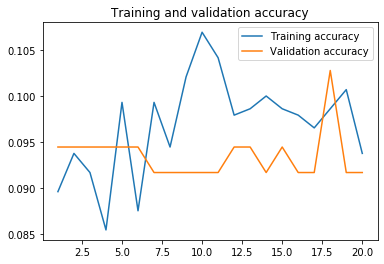

In [58]:
# Plotting training and validation accuracy

plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

Plotting validation and training losses and accuracy shows that the model's performance is bad with an accuracy of about 10%. This warrants a review of the model architecture used (Convoluted neural networks may work better than dense), hyperparameter tuning(changing the number of layers, number of hidden layers, epochs and batch size).

# Fitting the model on test data

Predictions contain the probability that the test data (400 datapoints) fall into each of the 10 categories(0 to 9)


In [ ]:
predictions = model.predict(test_data)